In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, validation_curve

In [3]:
df = pd.read_csv("~/projects/us-education-datasets-unification-project/data/us-education-datasets-unification-project/states_all.csv")

In [4]:
df.shape

(1492, 25)

In [5]:
np.sqrt(df.shape[0])
df.shape[0]/50

29.84

In [6]:
df.head(5)

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


In [7]:
df.columns.tolist()

['PRIMARY_KEY',
 'STATE',
 'YEAR',
 'ENROLL',
 'TOTAL_REVENUE',
 'FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE',
 'TOTAL_EXPENDITURE',
 'INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE',
 'GRADES_PK_G',
 'GRADES_KG_G',
 'GRADES_4_G',
 'GRADES_8_G',
 'GRADES_12_G',
 'GRADES_1_8_G',
 'GRADES_9_12_G',
 'GRADES_ALL_G',
 'AVG_MATH_4_SCORE',
 'AVG_MATH_8_SCORE',
 'AVG_READING_4_SCORE',
 'AVG_READING_8_SCORE']

In [8]:
set(df[df['AVG_MATH_4_SCORE']>0]['YEAR'].subtract(1).tolist())

{1991, 1995, 1999, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016}

In [9]:
shift_cols= ['PRIMARY_KEY', 'YEAR', 'STATE', 'AVG_MATH_4_SCORE']


In [10]:
df.notna().any().any()

True

In [11]:
# Function to return most recent test result
def most_recent_test(cur_yr, state, df):
    df_scratch= df.copy()
    df_scratch= df_scratch[df_scratch['STATE']==state]
    df_scratch= df_scratch[df_scratch['YEAR']<cur_yr]
    df_scratch= df_scratch[df_scratch['AVG_MATH_4_SCORE'].notna()]
    
    df_scratch.sort_values(by='YEAR')
    if df_scratch.notna().any().any(): 
        most_recent_test= df_scratch['AVG_MATH_4_SCORE'].iloc[-1]
    else:
        most_recent_test= 0 #Should handle these cases better
    return most_recent_test

In [12]:
most_recent_test(2009, 'VIRGINIA', df)

243.52112978321603

In [13]:
df[df['STATE']=='VIRGINIA'][df['YEAR'] <1997][['YEAR', 'AVG_MATH_4_SCORE']]

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,YEAR,AVG_MATH_4_SCORE
46,1992,220.762964
97,1993,NaN
148,1994,NaN
199,1995,NaN
250,1996,222.643213


In [88]:
df['recent_AVG_MATH_4_SCORE'].unique()

array([0.])

In [21]:
"""Use fcn above to add the new feature"""
for index, data in df.iterrows(): 
    recent_test= most_recent_test(cur_yr=data['YEAR'], state=data['STATE'], df=df)
    df.loc[index, 'recent_AVG_MATH_4_SCORE']= recent_test

"""
for year in set(df['YEAR'].tolist()):
    for state in set(df['STATE'].tolist()): 
        print(most_recent_test(year, state, df))
        df_scratch= df[df['YEAR'] == year]

"""

"\nfor year in set(df['YEAR'].tolist()):\n    for state in set(df['STATE'].tolist()): \n        print(most_recent_test(year, state, df))\n        df_scratch= df[df['YEAR'] == year]\n\n"

In [22]:
"""Failed attempts to make new recent_AVG_MATH_4_SCORE

shift_cols= ['PRIMARY_KEY', 'YEAR', 'STATE', 'AVG_MATH_4_SCORE']
df_shift= df[shift_cols].copy()
# print(df.shape, df_shift.shape)

year= df_shift['YEAR']
df_shift.loc['YEAR']= year-1
df_shift['YEAR'] = df_shift['YEAR'].astype(int)

df_shift.loc['PRIMARY_KEY']= "{}_{}".format(df_shift['YEAR'], df_shift['STATE'])
df_join= df.join(df_shift, on='PRIMARY_KEY', rsuffix='_shift')
"""

'''
print(df_join.shape)
print(df_shift['AVG_MATH_4_SCORE'].notna().sum())
print(df_join['AVG_MATH_4_SCORE_shift'].notna().sum())
print(df_join['AVG_MATH_4_SCORE'].notna().sum())

print(df_join['STATE_shift'].notna().sum())

print(df_shift['PRIMARY_KEY'])
'''

# df_join['recent_AVG_MATH_4_SCORE'] = df_join['AVG_MATH_4_SCORE_shift']
# df_join= df_join.drop(labels=['PRIMARY_KEY_shift', 'YEAR_shift', 'STATE_shift', 'AVG_MATH_4_SCORE_shift'], axis=1)

# print(df_join.shape, '\n', df_join)
# print(df_join['recent_AVG_MATH_4_SCORE'])
# print(df_join['AVG_MATH_4_SCORE'])

"\nprint(df_join.shape)\nprint(df_shift['AVG_MATH_4_SCORE'].notna().sum())\nprint(df_join['AVG_MATH_4_SCORE_shift'].notna().sum())\nprint(df_join['AVG_MATH_4_SCORE'].notna().sum())\n\nprint(df_join['STATE_shift'].notna().sum())\n\nprint(df_shift['PRIMARY_KEY'])\n"

In [23]:
print(np.count_nonzero(~np.isnan(df['recent_AVG_MATH_4_SCORE'])))
print(np.shape(df['recent_AVG_MATH_4_SCORE']))

print(df['recent_AVG_MATH_4_SCORE'].value_counts())


1492
(1492,)
0.000000      263
229.664564     11
220.319806      8
218.711935      8
221.562534      8
223.833455      7
215.025102      7
231.411851      7
215.763583      7
225.053298      7
225.805858      7
227.240167      7
226.212015      7
187.134670      4
213.698899      4
212.496714      4
222.634059      4
215.455862      4
214.965562      4
218.445535      4
221.037742      4
211.646974      4
225.332648      4
228.493596      4
204.140211      4
231.638840      4
215.594906      4
227.543993      4
212.884490      4
210.206028      4
             ... 
236.780986      2
230.043119      2
237.089571      2
245.156416      2
240.464624      2
241.684675      2
244.038622      2
236.262899      2
241.944909      2
230.029589      2
238.766859      2
241.990916      2
242.664321      2
237.810157      2
238.001730      2
238.173977      2
245.415854      2
227.612377      2
235.152274      2
236.328417      2
246.255335      2
235.510706      2
237.287041      2
235.668302     

In [24]:
print(key, lag_key)
print(df[df['PRIMARY_KEY']==key]['GRADES_12_G'])
print()
print(df[df['PRIMARY_KEY']==lag_key]['GRADES_8_G'])

2000_DOD 1996_DOD
Series([], Name: GRADES_12_G, dtype: float64)

1422    5306.0
Name: GRADES_8_G, dtype: float64


In [25]:
#Normalize expenditures to fraction of total expenditures
expenditure_cols = ['INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE']

for col in expenditure_cols:
    df['fracn_exp_{}'.format(col)] = df[col] / df['TOTAL_EXPENDITURE']
    #df=df.drop(col, axis=1)
    print('fracn_exp_{}'.format(col))

fracn_exp_INSTRUCTION_EXPENDITURE
fracn_exp_SUPPORT_SERVICES_EXPENDITURE
fracn_exp_OTHER_EXPENDITURE
fracn_exp_CAPITAL_OUTLAY_EXPENDITURE


In [26]:
#Normalize revenue to fraction of total revenue
revenue_cols = ['FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE']

for col in revenue_cols:
    df['fracn_rev_{}'.format(col)] = df[col] / df['TOTAL_REVENUE']
    #df=df.drop(col, axis=1)
    print('fracn_rev_{}'.format(col))

fracn_rev_FEDERAL_REVENUE
fracn_rev_STATE_REVENUE
fracn_rev_LOCAL_REVENUE


In [27]:
#Normalize students enrolled to fraction of enrolled population
fracn_enroll_cols = ['GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G']

for col in fracn_enroll_cols:
    df['fracn_enroll_{}'.format(col)] = df[col] / df['GRADES_ALL_G']
    print('fracn_enroll_{}'.format(col))
    #df = df.drop(col, axis=1) 

fracn_enroll_GRADES_PK_G
fracn_enroll_GRADES_KG_G
fracn_enroll_GRADES_4_G
fracn_enroll_GRADES_8_G
fracn_enroll_GRADES_12_G
fracn_enroll_GRADES_1_8_G
fracn_enroll_GRADES_9_12_G


In [31]:
df['avg_total_revenue']=df['TOTAL_REVENUE']/df['GRADES_ALL_G']
df['avg_total_expenditure'] = df['TOTAL_EXPENDITURE'] / df['GRADES_ALL_G']

df['fracn_schoolage'] = df['GRADES_ALL_G']/df['ENROLL']
df['rev_per_person'] = df['TOTAL_REVENUE'] / df['ENROLL']
df['exp_per_rev'] = df['TOTAL_EXPENDITURE'] / df['TOTAL_REVENUE']

df['recent_AVG_MATH_4_SCORE'] = np.zeros(len(df['PRIMARY_KEY']))

#Models want to know about drop-out rate
df['fracn_GRADES_12div8_G'] = np.zeros(len(df))
#Subtract take ratio GRADES_12_G(YEAR)/GRADES_8_G(YEAR-4)
for state in set(df['STATE'].tolist()):
    for year in set(df['YEAR'].tolist()):
        key= "{}_{}".format(year, state)
        lag_year = year-4
        lag_key= "{}_{}".format(lag_year, state)
        if np.any(df['PRIMARY_KEY']==lag_key):
            df.loc[df['PRIMARY_KEY']==key, ['fracn_GRADES_12div8_G']]= np.divide( \
                df[df['PRIMARY_KEY']==key]['GRADES_12_G'], np.median(df[df['PRIMARY_KEY']==lag_key]['GRADES_8_G']))

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [32]:
#sns.pairplot(df, kind='scatter')

(44, 44)


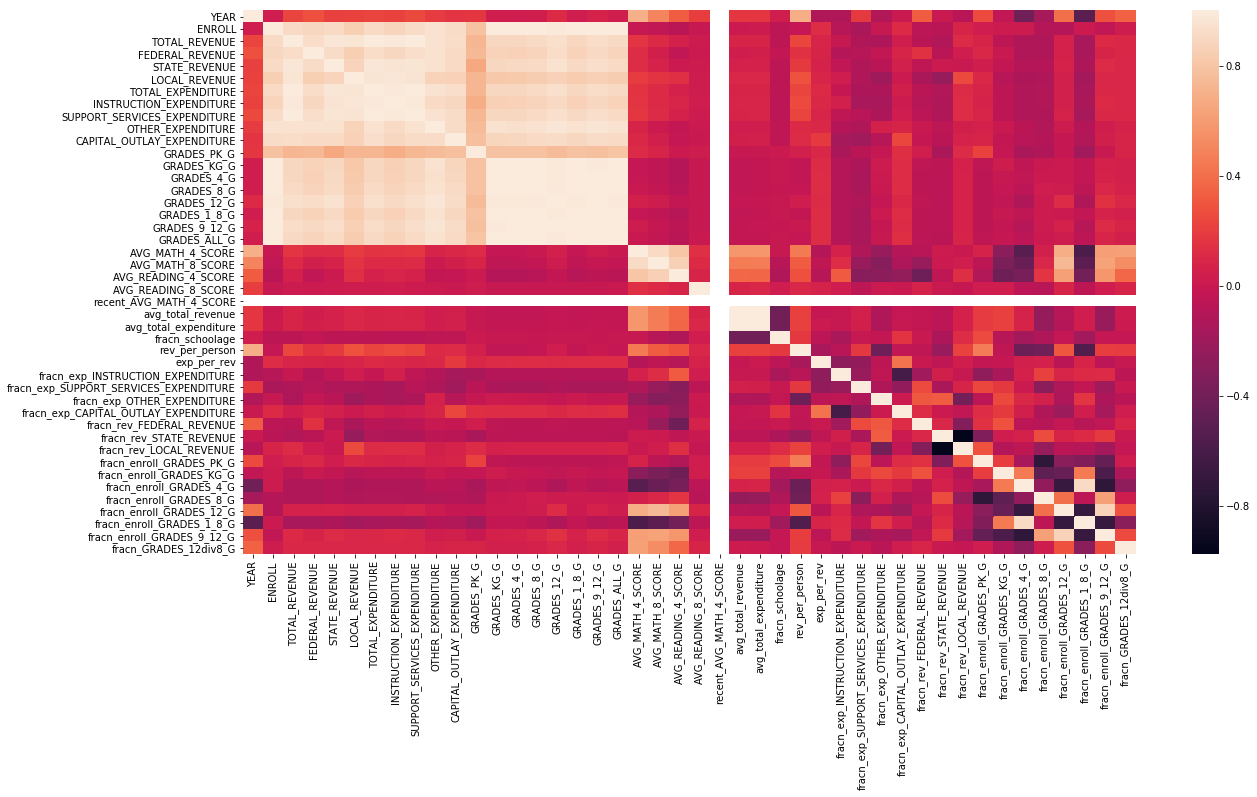

In [69]:
#plt.figure(figsize=(15,15))
corr = df.corr()
print(corr.shape)
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr)

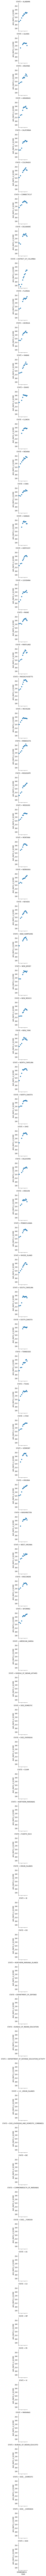

In [34]:
g = sns.FacetGrid(df, row="STATE") 
g.map(plt.scatter, 'YEAR', 'AVG_MATH_4_SCORE')

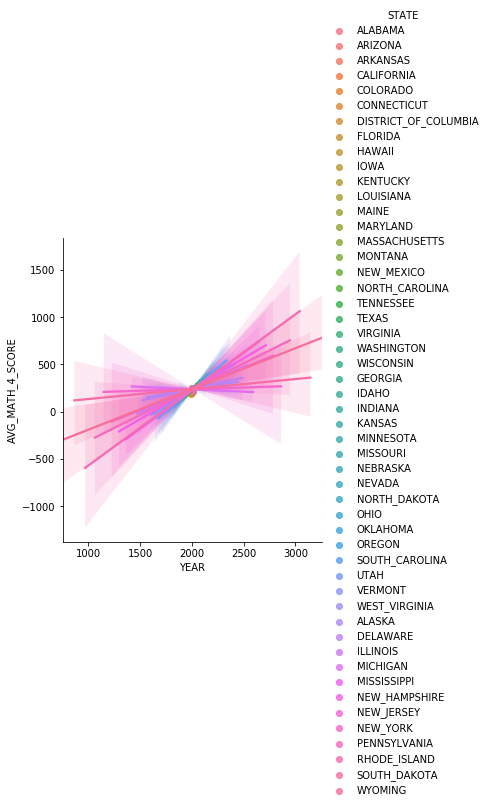

In [35]:
sns.lmplot(x="YEAR", y="AVG_MATH_4_SCORE", hue="STATE", data=df.dropna(), legend_out=True);

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


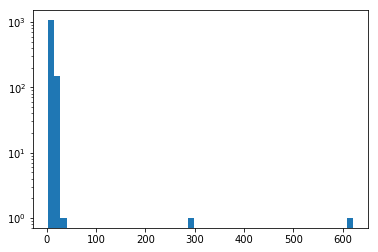

In [36]:
plt.hist('avg_total_expenditure', bins=50, log=True, data=df);

In [37]:
#For some reason VIRGINIA has 3 entries for 2008 and 2 of them have increicbly high avg_instruction_expenditure
df[df['avg_total_expenditure'] > 100]

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,fracn_rev_STATE_REVENUE,fracn_rev_LOCAL_REVENUE,fracn_enroll_GRADES_PK_G,fracn_enroll_GRADES_KG_G,fracn_enroll_GRADES_4_G,fracn_enroll_GRADES_8_G,fracn_enroll_GRADES_12_G,fracn_enroll_GRADES_1_8_G,fracn_enroll_GRADES_9_12_G,fracn_GRADES_12div8_G
863,2008_VIRGINIA,VIRGINIA,2008,1230857.0,14768120.0,897627.0,5957786.0,7912707.0,15236306.0,8003167.0,...,0.403422,0.535796,0.033129,0.105619,0.090875,0.075236,0.049372,0.716857,0.250015,0.026259
864,2008_VIRGINIA,VIRGINIA,2008,1230857.0,14768120.0,897627.0,5957786.0,7912707.0,15236306.0,8003167.0,...,0.403422,0.535796,0.104667,0.140873,0.103771,0.060479,0.019712,0.783009,0.112324,0.005013


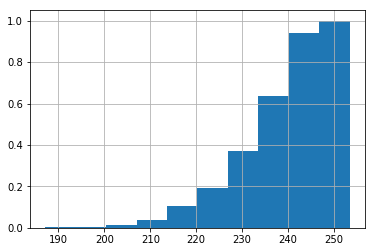

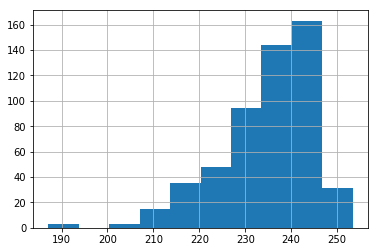

In [38]:
df['AVG_MATH_4_SCORE'].dropna().hist(density=True, cumulative=True)
plt.show()
df['AVG_MATH_4_SCORE'].dropna().hist()

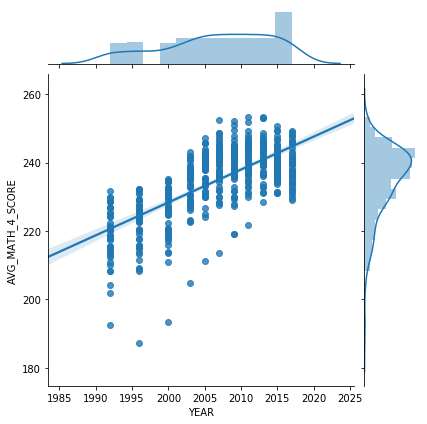

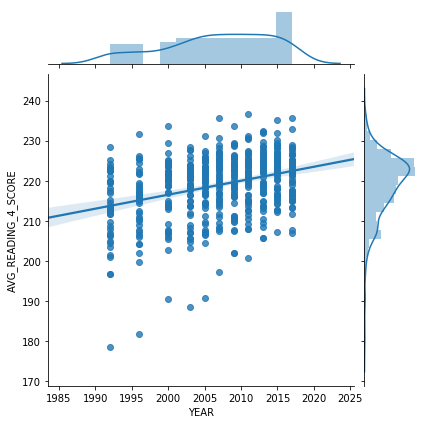

In [39]:
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")
sns.jointplot("YEAR", "AVG_READING_4_SCORE", data=df, kind="reg")

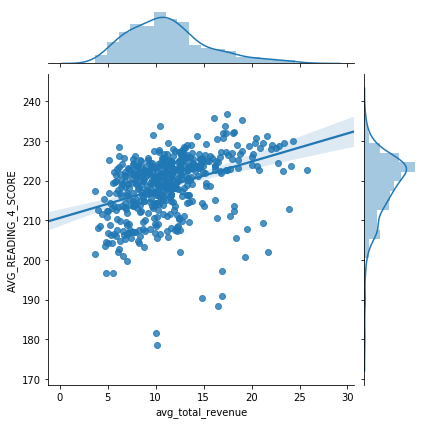

In [40]:
sns.jointplot("avg_total_revenue", "AVG_READING_4_SCORE", data=df, kind="reg")

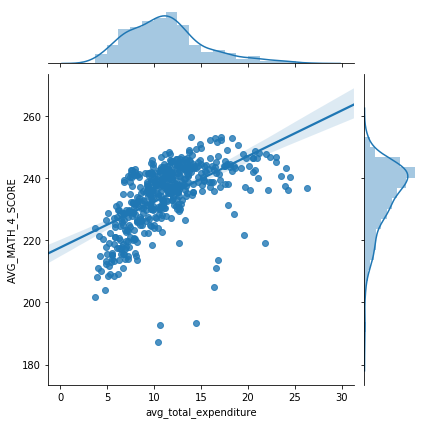

In [41]:
sns.jointplot("avg_total_expenditure", "AVG_MATH_4_SCORE", data=df, kind="reg")

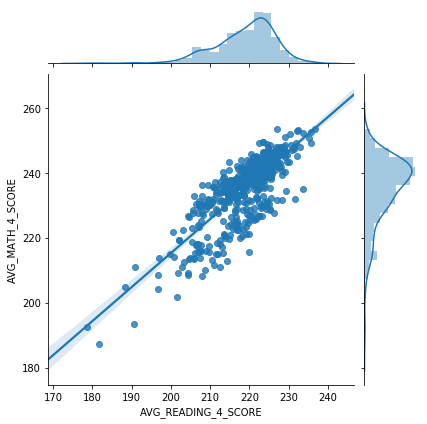

In [42]:
sns.jointplot("AVG_READING_4_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

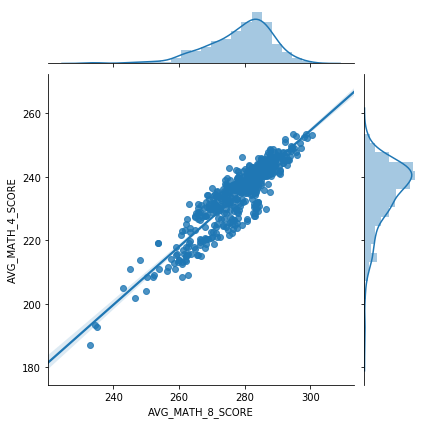

In [43]:
sns.jointplot("AVG_MATH_8_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

In [44]:
df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
print(df1.columns)
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

ts_cv = TimeSeriesSplit(n_splits=5)
print(ts_cv)
for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

"""
PredefinedSplit won't work because it folds in future data

test_fold = df1.loc[:,'YEAR'].values
ps = PredefinedSplit(test_fold)
print(ps.get_n_splits())
for train_index, test_index in ps.split():
    print("Train:", train_index, "Test:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
"""

Index(['STATE', 'YEAR', 'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE',
       'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE',
       'recent_AVG_MATH_4_SCORE', 'avg_total_revenue', 'avg_total_expenditure',
       'fracn_schoolage', 'rev_per_person', 'exp_per_rev',
       'fracn_exp_INSTRUCTION_EXPENDITURE',
       'fracn_exp_SUPPORT_SERVICES_EXPENDITURE', 'fracn_exp_OTHER_EXPENDITURE',
       'fracn_exp_CAPITAL_OUTLAY_EXPENDITURE', 'fracn_rev_FEDERAL_REVENUE',
       'fracn_rev_STATE_REVENUE', 'fracn_rev_LOCAL_REVENUE',
       'fracn_enroll_GRADES_PK_G', 'fracn_enroll_GRADES_KG_G',
       'fracn_enroll_GRADES_4_G', 'fracn_enroll_GRADES_8_G',
       'fracn_enroll_GRADES_12_G', 'fracn_enroll_GRADES_1_8_G',
       'fr

'\nPredefinedSplit won\'t work because it folds in future data\n\ntest_fold = df1.loc[:,\'YEAR\'].values\nps = PredefinedSplit(test_fold)\nprint(ps.get_n_splits())\nfor train_index, test_index in ps.split():\n    print("Train:", train_index, "Test:", test_index)\n    X_train, X_test = X[train_index], X[test_index]\n    y_train, y_test = y[train_index], y[test_index]    \n'

In [45]:
n_splits=20
ts_cv = TimeSeriesSplit(n_splits=n_splits)
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1)

index=0
train_score = np.zeros(n_splits)
test_score = np.zeros(n_splits)

for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]   
    
    rf_model.fit(X_train, y_train) 
    Y_rf=rf_model.predict(X_test)
    train_score[index]=rf_model.score(X_train,y_train) #Train score
    test_score[index]=rf_model.score(X_test,y_test) #Test score
    index+=1
index_list=np.arange(index)

In [46]:
print(index)
print(index_list)
print(train_score)
print(test_score)

20
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0.89132127 0.93361508 0.94567205 0.94424923 0.94980161 0.95419831
 0.95672281 0.9659101  0.96929472 0.97290935 0.97039332 0.97232234
 0.97414613 0.97382579 0.97638734 0.97485717 0.9723839  0.97297409
 0.97527407 0.97634031]
[ 0.67862862  0.36096471 -0.06872788 -0.13629825  0.28421345  0.45743873
  0.13451886  0.69552544  0.55004926  0.53434244  0.68243461  0.68512823
  0.72766381  0.52589306  0.33277086  0.36631297  0.67728781  0.50778621
  0.6818597   0.54449702]


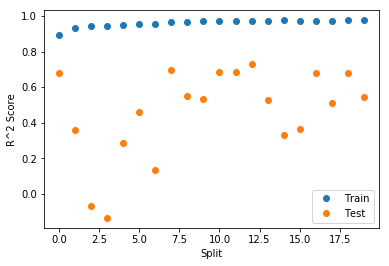

In [47]:
plt.plot(index_list,train_score,'o', label="Train")
plt.plot(index_list,test_score,'o', label="Test")
plt.xlabel("Split")
plt.ylabel("R^2 Score")
plt.legend(loc="best")

In [48]:
model=RandomForestRegressor()

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

"""
param_search = [
  {'n_estimators': [1, 10, 20, 100]}
]
gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
gsrch_rf_model.fit(X,y)
"""

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[4,5,6,7,8,9,10,20,30,40,50,60]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, cv=ts_cv, n_jobs=-1)

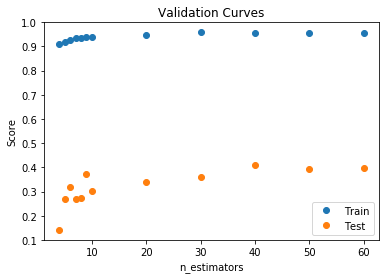

In [49]:
train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train")
plt.plot(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

In [50]:
model=RandomForestRegressor(n_estimators=20)

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=30), cv=ts_cv, n_jobs=-1)

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:1310: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes' 19 instead of 30).
  % (train_sizes_abs.shape[0], n_ticks), RuntimeWarning)


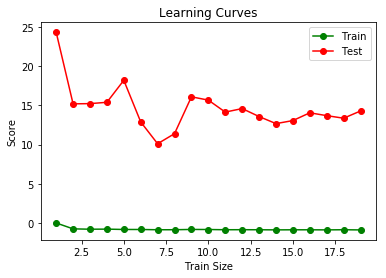

In [51]:
plt.figure()
plt.plot(train_sizes, -train_scores.mean(1), 'o-', color="g",
         label="Train")
plt.plot(train_sizes, -test_scores.mean(1), 'o-', color="r",
         label="Test")
plt.xlabel("Train Size")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")

In [52]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

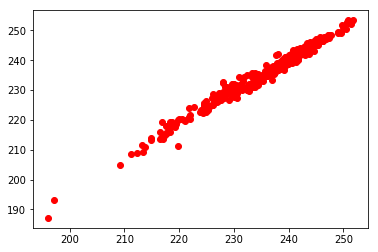

In [53]:
Y_rf=rf_model.predict(X)
plt.plot(Y_rf, y, 'ro')
plt.show()

In [54]:
rf_model.score(X,y)

0.9759419526198378

In [55]:
feature_importances_rf = pd.DataFrame(rf_model.feature_importances_, index = df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importances_rf.head(10)

,importance
YEAR,0.432763
fracn_enroll_GRADES_12_G,0.108953
fracn_GRADES_12div8_G,0.095476
fracn_rev_FEDERAL_REVENUE,0.048330
fracn_exp_SUPPORT_SERVICES_EXPENDITURE,0.025834
avg_total_revenue,0.025268
fracn_rev_LOCAL_REVENUE,0.019562
avg_total_expenditure,0.015751
fracn_schoolage,0.013490
GRADES_ALL_G,0.011929


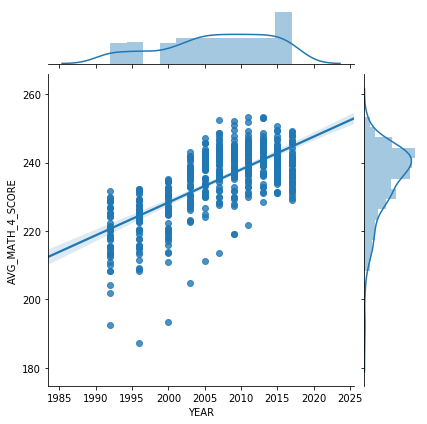

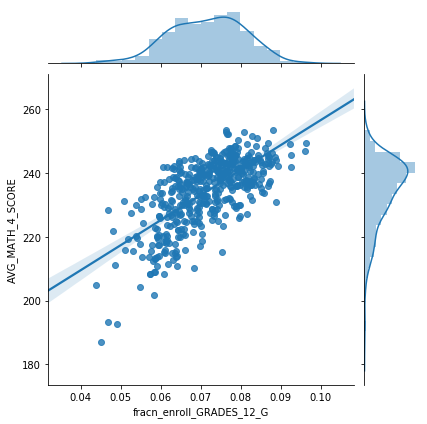

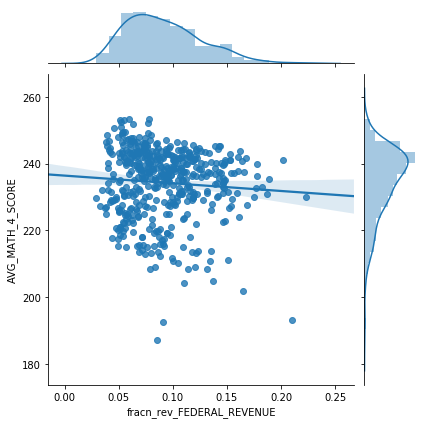

In [56]:
sns.jointplot(x='YEAR', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_enroll_GRADES_12_G', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_rev_FEDERAL_REVENUE', y='AVG_MATH_4_SCORE', data=df, kind='reg')

In [57]:
from sklearn import svm
svm_model = svm.SVR(gamma='scale')
svm_model.fit(X, y)  

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

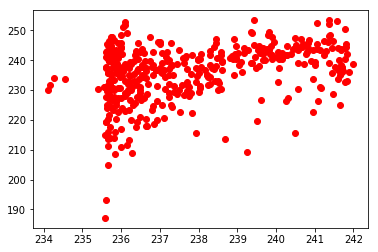

In [58]:
Y_svm=svm_model.predict(X)
plt.plot(Y_svm, y, 'ro')
plt.show()

# Lasso

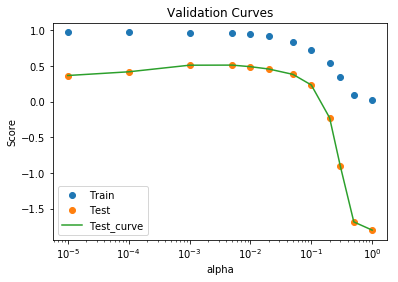

In [59]:
model=linear_model.Lasso(normalize=True)
param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="alpha", param_range=param_range, cv=ts_cv, n_jobs=-1)

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

(30,) (30, 5) (30, 5)


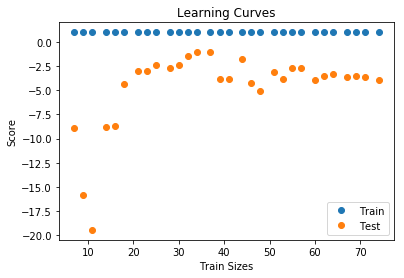

In [72]:
model=linear_model.Lasso(alpha=0.01, normalize=True)
#lasso_model.fit(X, y)  
#Y_lasso=lasso_model.predict(X)

num_splits=5
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=30), cv=ts_cv, n_jobs=-1)

print(train_sizes.shape,train_scores.shape, test_scores.shape)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes,train_scores_mean,'o',label="Train")
plt.plot(train_sizes,test_scores_mean,'o',label="Test")
plt.xlabel("Train Sizes")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")

In [73]:
"""Plot test data fit"""

'Plot test data fit'

Text(0, 0.5, 'y')

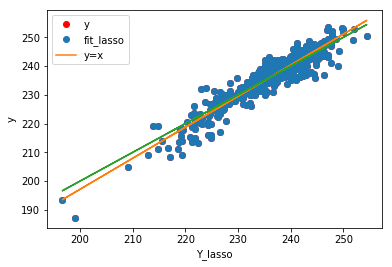

In [76]:

lasso_model=linear_model.Lasso(alpha=0.01, normalize=True)
lasso_model.fit(X, y)  
Y_lasso=lasso_model.predict(X)
plt.plot(Y_lasso, y, 'ro')

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

In [77]:
lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_.round(), X_cols))

(90,)
(90,)
[   1.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    0.    0.   -0.
   -0.   -0.   -0.   -0.   -0.   -0.    0.    0.    0.    0.    0.    0.
   -0.  -30.  -21.    6.   -0.   -0.    0.   -0.    0. -259.  109.  185.
   -0.   48.    0.   -6.   -2.   -3.   -1.   -8.    2.    2.   -0.  -12.
    0.   -0.   -0.    0.   -1.    4.   -0.    3.   -0.   -2.    0.    0.
    8.   -1.    1.   -5.   -0.    0.   -1.   -1.    5.    4.   -7.   -2.
    5.    0.    2.    0.   -0.   -0.   -0.   -0.    0.   -2.    4.    0.
    0.    3.    0.   -2.    0.    2.]


[(-259.0, 'fracn_enroll_GRADES_4_G'),
 (-30.0, 'fracn_exp_SUPPORT_SERVICES_EXPENDITURE'),
 (-21.0, 'fracn_exp_OTHER_EXPENDITURE'),
 (-12.0, 'STATE_DISTRICT_OF_COLUMBIA'),
 (-8.0, 'STATE_CALIFORNIA'),
 (-7.0, 'STATE_NEW_MEXICO'),
 (-6.0, 'STATE_ALABAMA'),
 (-5.0, 'STATE_MISSISSIPPI'),
 (-3.0, 'STATE_ARIZONA'),
 (-2.0, 'STATE_ALASKA'),
 (-2.0, 'STATE_LOUISIANA'),
 (-2.0, 'STATE_NEW_YORK'),
 (-2.0, 'STATE_TENNESSEE'),
 (-2.0, 'STATE_WEST_VIRGINIA'),
 (-1.0, 'STATE_ARKANSAS'),
 (-1.0, 'STATE_ILLINOIS'),
 (-1.0, 'STATE_MICHIGAN'),
 (-1.0, 'STATE_NEBRASKA'),
 (-1.0, 'STATE_NEVADA'),
 (0.0, 'CAPITAL_OUTLAY_EXPENDITURE'),
 (-0.0, 'FEDERAL_REVENUE'),
 (-0.0, 'GRADES_12_G'),
 (-0.0, 'GRADES_1_8_G'),
 (-0.0, 'GRADES_4_G'),
 (-0.0, 'GRADES_8_G'),
 (-0.0, 'GRADES_9_12_G'),
 (-0.0, 'GRADES_ALL_G'),
 (-0.0, 'GRADES_KG_G'),
 (0.0, 'GRADES_PK_G'),
 (-0.0, 'INSTRUCTION_EXPENDITURE'),
 (-0.0, 'LOCAL_REVENUE'),
 (-0.0, 'OTHER_EXPENDITURE'),
 (-0.0, 'STATE_DELAWARE'),
 (0.0, 'STATE_FLORIDA'),
 (-0.0, 'STAT

In [84]:
scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

model=linear_model.Lasso(alpha=0.01, normalize=True)
lasso_model.fit(X_transformed, y)  
Y_lasso=lasso_model.predict(X_transformed)

lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_, X_cols))

(90,)
(90,)
[ 5. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0.
  0.  0.  0.  0.  0.  0. -0. -1. -0.  0. -0. -0.  0. -0.  0. -1.  0.  2.
 -0.  1.  0. -1. -0. -0. -0. -1.  0.  0. -0. -2.  0. -0. -0.  0. -0.  1.
 -0.  0. -0. -0.  0.  0.  1. -0.  0. -1. -0.  0. -0. -0.  1.  1. -1. -0.
  1.  0.  0.  0. -0. -0. -0. -0.  0. -0.  1.  0.  0.  0.  0. -0.  0.  0.]


[(-1.8235948435688876, 'STATE_DISTRICT_OF_COLUMBIA'),
 (-1.0425745393877095, 'STATE_CALIFORNIA'),
 (-0.9830074515230623, 'fracn_exp_SUPPORT_SERVICES_EXPENDITURE'),
 (-0.9624269561120681, 'STATE_NEW_MEXICO'),
 (-0.9506549065962288, 'fracn_enroll_GRADES_4_G'),
 (-0.8967949845865878, 'STATE_ALABAMA'),
 (-0.7773189258344766, 'STATE_MISSISSIPPI'),
 (-0.44277591757183393, 'STATE_ARIZONA'),
 (-0.32426532650483963, 'fracn_exp_OTHER_EXPENDITURE'),
 (-0.27867242400788306, 'STATE_NEW_YORK'),
 (-0.2746604602594089, 'STATE_TENNESSEE'),
 (-0.26880067648999445, 'STATE_WEST_VIRGINIA'),
 (-0.23722827080234138, 'STATE_LOUISIANA'),
 (-0.22251170073639864, 'STATE_ALASKA'),
 (-0.19881241154306908, 'STATE_NEVADA'),
 (-0.16146661111124766, 'STATE_NEBRASKA'),
 (-0.13818405496593691, 'STATE_ARKANSAS'),
 (-0.079690162987306, 'STATE_MICHIGAN'),
 (-0.07021601813489702, 'STATE_ILLINOIS'),
 (-0.06597088357897404, 'STATE_OREGON'),
 (-0.013842831243349323, 'STATE_RHODE_ISLAND'),
 (0.0, 'CAPITAL_OUTLAY_EXPENDITURE'),


Text(0, 0.5, 'y')

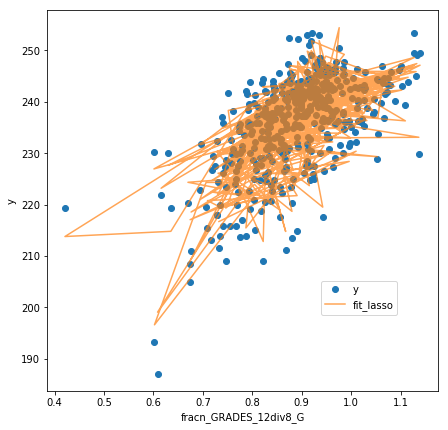

In [79]:
"""fracn_GRADES_12div8_G
is not chosen by Lasso. RandomForest says it's #2 tho. Why?
Plot.
"""
plt.figure(figsize=[7,7])
x1=df1.loc[:,'fracn_GRADES_12div8_G'].values
plt.plot(x1,y,'o')
plt.plot(x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_GRADES_12div8_G")
plt.ylabel("y")

(439,) (439, 90) (439,)
(439,) (439, 90) (439,)
(439,) (439, 90) (439,)
(439,) (439, 90) (439,)


Text(0, 0.5, 'y')

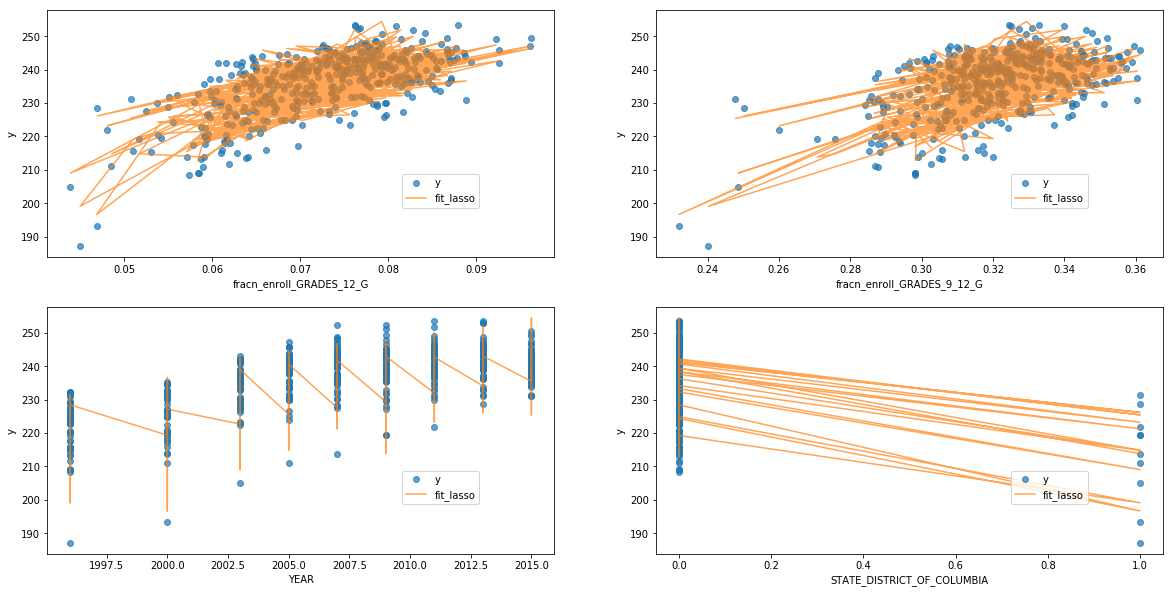

In [80]:
plt.figure(figsize=[20,10])

plt.subplot(2, 2, 1)
x1=df1.loc[:,'fracn_enroll_GRADES_12_G'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_enroll_GRADES_12_G")
plt.ylabel("y")

plt.subplot(2, 2, 2)
x1=df1.loc[:,'fracn_enroll_GRADES_9_12_G'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_enroll_GRADES_9_12_G")
plt.ylabel("y")

plt.subplot(2, 2, 3)
x1=df1.loc[:,'YEAR'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("YEAR")
plt.ylabel("y")

plt.subplot(2, 2, 4)
x1=df1.loc[:,'STATE_DISTRICT_OF_COLUMBIA'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("STATE_DISTRICT_OF_COLUMBIA")
plt.ylabel("y")

Text(0, 0.5, 'y')

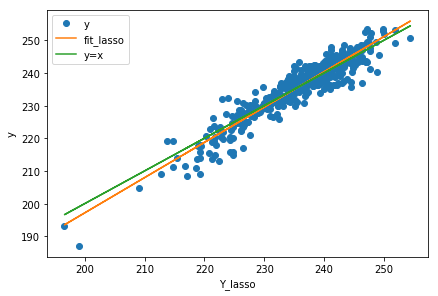

In [81]:
plt.figure(figsize=[15,10])

plt.subplot(2, 2, 1)
plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

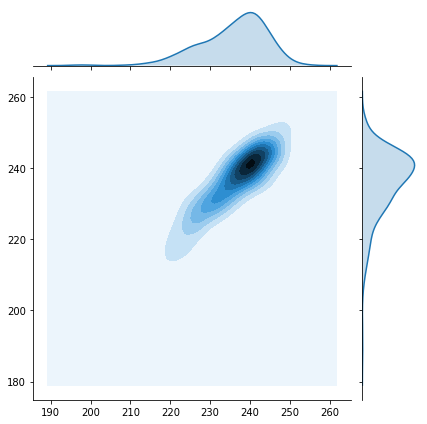

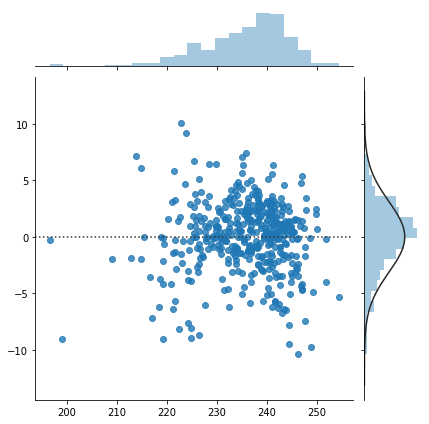

In [82]:
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

#need to make analysis_df that has y,Y_lasso

#Plot
#grid=sns.JointGrid(x=Y_lasso,y=y)
#g=grid.plot_joint(sns.scatterplot) #, hue='smoker'
#sns.scatterplot(Y_lasso,line, ax=g.ax_marg_x, legend=False)
#sns.lmplot(Y_lasso,Y_lasso,ax=g.ax_marg_x,legend=False)

#plt.subplot(1,2,1)
ax1 = sns.jointplot(x=Y_lasso,y=y,kind="kde")
#plt.subplot(1,2,2)
ax2 = sns.jointplot(x=Y_lasso,y=y,kind="resid")

TypeError: 'list' object is not callable

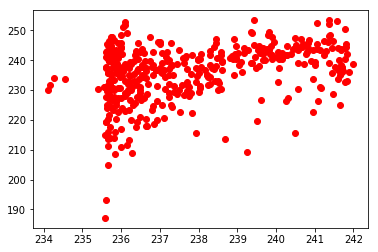

In [83]:
"""The largest coefficients are"""
X_cols[np.abs(lasso_coef_)>0.5]
""". Plot them with fits."""

plt.plot(Y_svm, y, 'ro')("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")


In [ ]:
"""
Can I predict test scores for a year?

Handle time better. Time_series_split

Time trends: 
-Scores
-Populations
-Revenues
-Expenditures

Delta from previous time point as feature?

Features:
-Elite? financials, location, 
-Good school? school history, tax rev, district
-Trends in time? Deltas in time. more money, more students, higher scores, ...


"""